In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from typing import *

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 150)
pd.set_option('display.max_colwidth', None)
pd.set_option('future.no_silent_downcasting', True)
sns.set()

df = pd.read_csv('data_part_2.csv')

print(df.shape)
df.head()

(1009, 18)


,user_id,region,device,channel,session_start,session_end,sessiondurationsec,session_date,month,day,hour_of_day,order_dt,revenue,payment_type,promo_code,final_price,time_of_day,sold
0,529697267522,United States,iPhone,социальные сети,2019-05-01 00:06:40,2019-05-01 00:07:06,26.0,2019-05-01,5,3,0,2019-05-01 00:06:40,9999.0,Mobile payments,0.0,9999.0,night,1
1,601292388085,United States,PC,organic,2019-05-01 06:56:16,2019-05-01 07:09:18,782.0,2019-05-01,5,3,7,NaN,NaN,NaN,NaN,NaN,morning,0
2,852898876338,United States,Mac,социальные сети,2019-05-01 04:30:45,2019-05-01 04:34:56,251.0,2019-05-01,5,3,4,NaN,NaN,NaN,NaN,NaN,night,0
3,998513020664,United States,iPhone,социальные сети,2019-05-01 18:53:42,2019-05-01 18:57:35,233.0,2019-05-01,5,3,18,NaN,NaN,NaN,NaN,NaN,evening,0
4,240702200943,United States,Mac,социальные сети,2019-05-02 14:04:32,2019-05-02 14:09:51,319.0,2019-05-02,5,4,14,NaN,NaN,NaN,NaN,NaN,day,0


# Set Proper Data Types

In [2]:
dtype_mapping = {
    'user_id': 'int64', 
    'region': 'object', 
    'device': 'object', 
    'channel': 'object', 
    'session_start': 'datetime64[ns]', 
    'session_end': 'datetime64[ns]', 
    'sessiondurationsec': 'float64', 
    'session_date': 'datetime64[ns]', 
    'month': 'int64', 
    'day': 'int64', 
    'hour_of_day': 'int64', 
    'order_dt': 'datetime64[ns]', 
    'revenue': 'float64', 
    'payment_type': 'object', 
    'promo_code': 'float64'
}

df = df.astype(dtype_mapping)

# Custom Functions

In [ ]:
def aggregate_daily_purchases(
    data: pd.DataFrame,
    group_cols: List[str] = ['region', 'device'],
    date_col: str = 'session_date',
    target_col: str = 'sold'
) -> pd.DataFrame:
    daily_purchases = (data
                      .groupby([date_col] + group_cols)[target_col]
                      .sum()
                      .reset_index())
    
    return daily_purchases

def test_and_visualize_normality(
    data: pd.DataFrame,
    target_col: str = 'sold',
    hue_col: str = 'region',
    figsize: tuple = (15, 6)
) -> dict:
    """
    Tests overall normality of the target variable and creates visualization plots.
    
    Parameters
    ----------
    data : pd.DataFrame
        Data containing purchase counts
    target_col : str
        Column containing values to test for normality
    hue_col : str
        Column to use for coloring in KDE plot
    figsize : tuple
        Figure size for plots
        
    Returns
    -------
    dict
        Results of Shapiro-Wilk test
    """
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    # Q-Q plot
    stats.probplot(data[target_col], dist="norm", plot=ax1)
    ax1.set_title('Q-Q Plot of Purchase Counts')
    
    # KDE plot
    sns.kdeplot(
        data=data,
        x=target_col,
        hue=hue_col,
        common_norm=False,
        ax=ax2
    )
    ax2.set_title('Distribution of Purchase Counts')
    
    # Statistical test
    stat, p_value = stats.shapiro(data[target_col])
    
    results = {
        'n_samples': len(data),
        'shapiro_stat': stat,
        'p_value': p_value
    }
    
    plt.tight_layout()
    
    return results

def test_device_effect(
    data: pd.DataFrame,
    group_cols: List[str] = ['region', 'device'],
    target_col: str = 'sold',
    alpha: float = 0.05
) -> Dict[str, pd.DataFrame]:
    """
    Tests effect of device type on purchases for each region.
    
    Parameters
    ----------
    data : pd.DataFrame
        Purchase data
    group_cols : List[str]
        [region_column, device_column]
    target_col : str
        Column with purchase counts
    alpha : float
        Significance level
        
    Returns
    -------
    Dict with two DataFrames:
        - kruskal: Results of Kruskal-Wallis tests
        - posthoc: Results of pairwise Mann-Whitney U tests
    """
    results_kw = []
    results_mw = []
    
    # For each region
    for region in data[group_cols[0]].unique():
        region_data = data[data[group_cols[0]] == region]
        
        # Get device groups
        device_groups = [group[target_col].values 
                        for name, group in region_data.groupby(group_cols[1])]
        
        # Kruskal-Wallis test
        h_stat, p_value = stats.kruskal(*device_groups)
        
        results_kw.append({
            'region': region,
            'h_statistic': h_stat,
            'p_value': p_value,
            'significant': p_value < alpha
        })
        
        # If Kruskal-Wallis is significant, do post-hoc
        if p_value < alpha:
            devices = region_data[group_cols[1]].unique()
            
            # Number of pairwise comparisons for Bonferroni
            n_comparisons = len(devices) * (len(devices) - 1) / 2
            adjusted_alpha = alpha / n_comparisons
            
            # Pairwise Mann-Whitney U tests
            for i in range(len(devices)):
                for j in range(i + 1, len(devices)):
                    dev1_data = region_data[region_data[group_cols[1]] == devices[i]][target_col]
                    dev2_data = region_data[region_data[group_cols[1]] == devices[j]][target_col]
                    
                    stat, p_value = stats.mannwhitneyu(
                        dev1_data, 
                        dev2_data,
                        alternative='two-sided'
                    )
                    
                    results_mw.append({
                        'region': region,
                        'device1': devices[i],
                        'device2': devices[j],
                        'statistic': stat,
                        'p_value': p_value,
                        'significant': p_value < adjusted_alpha
                    })
    
    results = {
        'kruskal': pd.DataFrame(results_kw),
        'posthoc': pd.DataFrame(results_mw) if results_mw else None
    }
    
    return results


# Does device type influence the number of daily purchases across regions?

# Step 1: Prepare Data and State Hypotheses

In [3]:
def aggregate_daily_purchases(data: pd.DataFrame) -> pd.DataFrame:
    """Aggregates data to daily purchase counts"""
    daily_purchases = (data
                      .groupby(['session_date', 'region', 'device'])['sold']
                      .sum()
                      .reset_index())
    return daily_purchases

daily_data = aggregate_daily_purchases(df)

# Step 2: Test for Normality
## H0: Data follows normal distribution
## H1: Data does not follow normal distribution

p_value = 9.491413494873924e-36


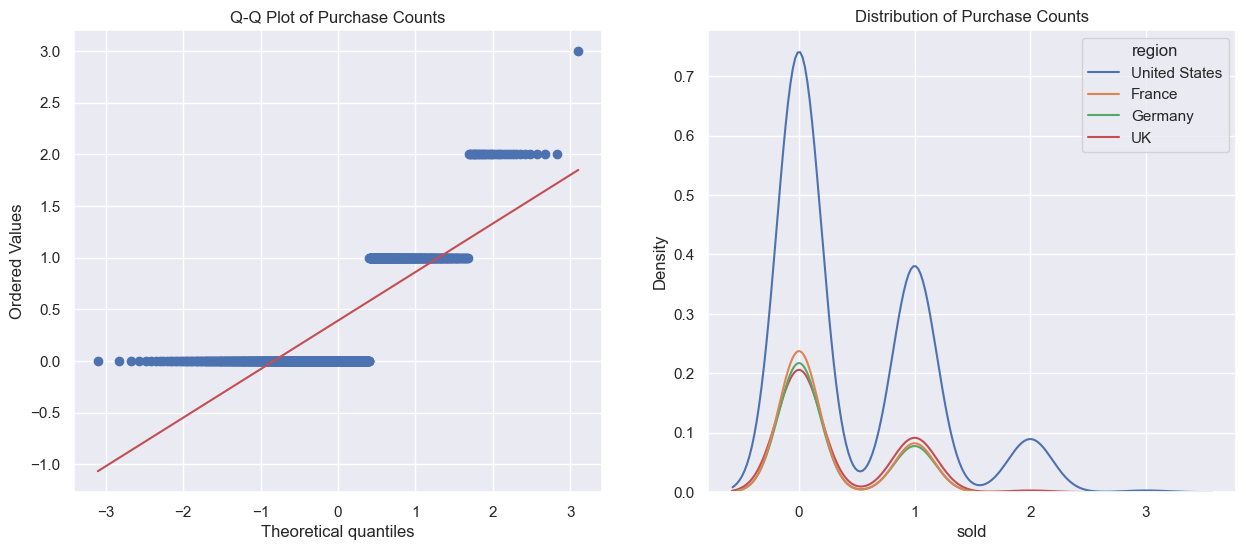

In [4]:
def test_normality(data: pd.DataFrame, target_col: str = 'sold') -> dict:
    """Tests overall normality of purchase counts"""
    # Q-Q plot and KDE plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Q-Q plot
    stats.probplot(data[target_col], dist="norm", plot=ax1)
    ax1.set_title('Q-Q Plot of Purchase Counts')
    
    # KDE plot by region
    sns.kdeplot(data=data, x=target_col, hue='region', ax=ax2)
    ax2.set_title('Distribution of Purchase Counts')
    
    # Shapiro-Wilk test
    stat, p_value = stats.shapiro(data[target_col])
    
    return {'n_samples': len(data),
            'shapiro_stat': stat,
            'p_value': p_value}

normality_results = test_normality(daily_data)
print(f'p_value = {normality_results['p_value']}')
# Result: p_value ≈ 9.49e-36 << 0.05, strongly non-normal

# Step 3: Based on non-normality, first try Kruskal-Wallis test for 4 devices
## H0: Distribution of daily purchases is the same across all device types
## H1: Distributions differ for at least one device type

In [5]:
def test_device_effect(data: pd.DataFrame, alpha: float = 0.05) -> pd.DataFrame:
    """Tests effect of device type on purchases for each region"""
    results = []
    
    for region in data['region'].unique():
        region_data = data[data['region'] == region]
        device_groups = [group['sold'].values 
                        for name, group in region_data.groupby('device')]
        
        h_stat, p_value = stats.kruskal(*device_groups)
        
        results.append({
            'region': region,
            'h_statistic': h_stat,
            'p_value': p_value,
            'significant': p_value < alpha
        })
    
    return pd.DataFrame(results)

# First attempt with 4 devices
kw_results = test_device_effect(daily_data)
print(kw_results)
# Result: No significant differences found

          region  h_statistic   p_value  significant
0  United States     3.423439  0.330828        False
1         France     4.748734  0.191148        False
2        Germany     1.680685  0.641236        False
3             UK     1.177001  0.758526        False


# Step 4: Logical Regrouping of Devices
## Given no significant results and logical similarity of devices, <br />combine into mobile (iPhone + Android) vs desktop (Mac + PC)

In [6]:
def test_mobile_vs_desktop(data: pd.DataFrame) -> pd.DataFrame:
    """Tests mobile vs desktop devices effect on purchases"""
    # Create device categories
    data = data.copy()
    data['device_type'] = data['device'].map({
        'iPhone': 'mobile',
        'Android': 'mobile',
        'Mac': 'desktop',
        'PC': 'desktop'
    })
    
    results = []
    for region in data['region'].unique():
        region_data = data[data['region'] == region]
        daily_data = region_data.groupby(['session_date', 'device_type'])['sold'].sum().reset_index()
        
        mobile_data = daily_data[daily_data['device_type'] == 'mobile']['sold']
        desktop_data = daily_data[daily_data['device_type'] == 'desktop']['sold']
        
        # Mann-Whitney U test (for two groups)
        stat, pval = stats.mannwhitneyu(
            mobile_data, 
            desktop_data, 
            alternative='two-sided'
        )
        
        results.append({
            'region': region,
            'statistic': stat,
            'p_value': pval,
            'mobile_mean': mobile_data.mean(),
            'desktop_mean': desktop_data.mean(),
            'mobile_n': len(mobile_data),
            'desktop_n': len(desktop_data)
        })
    df = pd.DataFrame(results)
    df['significant'] = df['p_value'] < 0.05
    return df

final_results = test_mobile_vs_desktop(daily_data)
print(final_results)

          region  statistic   p_value  mobile_mean  desktop_mean  mobile_n  desktop_n  significant
0  United States    12650.5  0.029154     0.755952      0.526316       168        133         True
1         France     1012.5  0.492671     0.222222      0.333333        45         48        False
2        Germany     1081.5  0.331919     0.326087      0.232558        46         43        False
3             UK     1165.0  0.720463     0.377778      0.340000        45         50        False


# Conclusions:
1. Data is significantly non-normal (p < 0.05)
2. Initial Kruskal-Wallis test with 4 devices showed no significant differences
3. After combining into mobile/desktop:
   - Significant difference found in USA (p = 0.029 < 0.05)
   - USA shows higher mobile purchases (mean 0.76 vs 0.53)
   - No significant differences in other regions
   - Other regions have much smaller sample sizes

Answer to research question:
Yes, device type does influence daily purchases, specifically:
- Effect found in USA market
- Mobile devices show higher daily purchase rates
- Effect not detected in other regions (possibly due to small samples)